In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## 1. 학습 로그 데이터 로드 및 시각화

In [ ]:
# 학습 로그 파일 읽기
resnet_log = pd.read_csv('./log/resnet_training_log.txt', sep='\t')
vit_log = pd.read_csv('./log/vit_training_log.txt', sep='\t')

print("ResNet 학습 결과:")
print(resnet_log.tail())
print(f"\n최종 Train Acc: {resnet_log['Train Acc'].iloc[-1]:.4f}")
print(f"최종 Test Acc: {resnet_log['Test Acc'].iloc[-1]:.4f}")
print(f"최고 Test Acc: {resnet_log['Test Acc'].max():.4f}")
if 'Test F1' in resnet_log.columns:
    print(f"최종 Test F1: {resnet_log['Test F1'].iloc[-1]:.4f}")
    print(f"최고 Test F1: {resnet_log['Test F1'].max():.4f}")

print("\n" + "="*50)
print("ViT 학습 결과:")
print(vit_log.tail())
print(f"\n최종 Train Acc: {vit_log['Train Acc'].iloc[-1]:.4f}")
print(f"최종 Test Acc: {vit_log['Test Acc'].iloc[-1]:.4f}")
print(f"최고 Test Acc: {vit_log['Test Acc'].max():.4f}")
if 'Test F1' in vit_log.columns:
    print(f"최종 Test F1: {vit_log['Test F1'].iloc[-1]:.4f}")
    print(f"최고 Test F1: {vit_log['Test F1'].max():.4f}")

ResNet 학습 결과:
    Epoch  Train Loss  Train Acc  Test Loss  Test Acc
25     26      0.6437     0.7222     1.4527    0.4835
26     27      0.6313     0.7266     1.4659    0.4860
27     28      0.6273     0.7270     1.4986    0.4827
28     29      0.6191     0.7305     1.5464    0.4865
29     30      0.6148     0.7324     1.5379    0.4835

최종 Train Acc: 0.7324
최종 Test Acc: 0.4835
최고 Test Acc: 0.5181

ViT 학습 결과:
    Epoch  Train Loss  Train Acc  Test Loss  Test Acc
25     26      0.5531     0.7432     1.5173    0.4806
26     27      0.5511     0.7409     1.5046    0.4802
27     28      0.5437     0.7419     1.5293    0.4767
28     29      0.5385     0.7430     1.5987    0.4848
29     30      0.5349     0.7449     1.5456    0.4825

최종 Train Acc: 0.7449
최종 Test Acc: 0.4825
최고 Test Acc: 0.5241


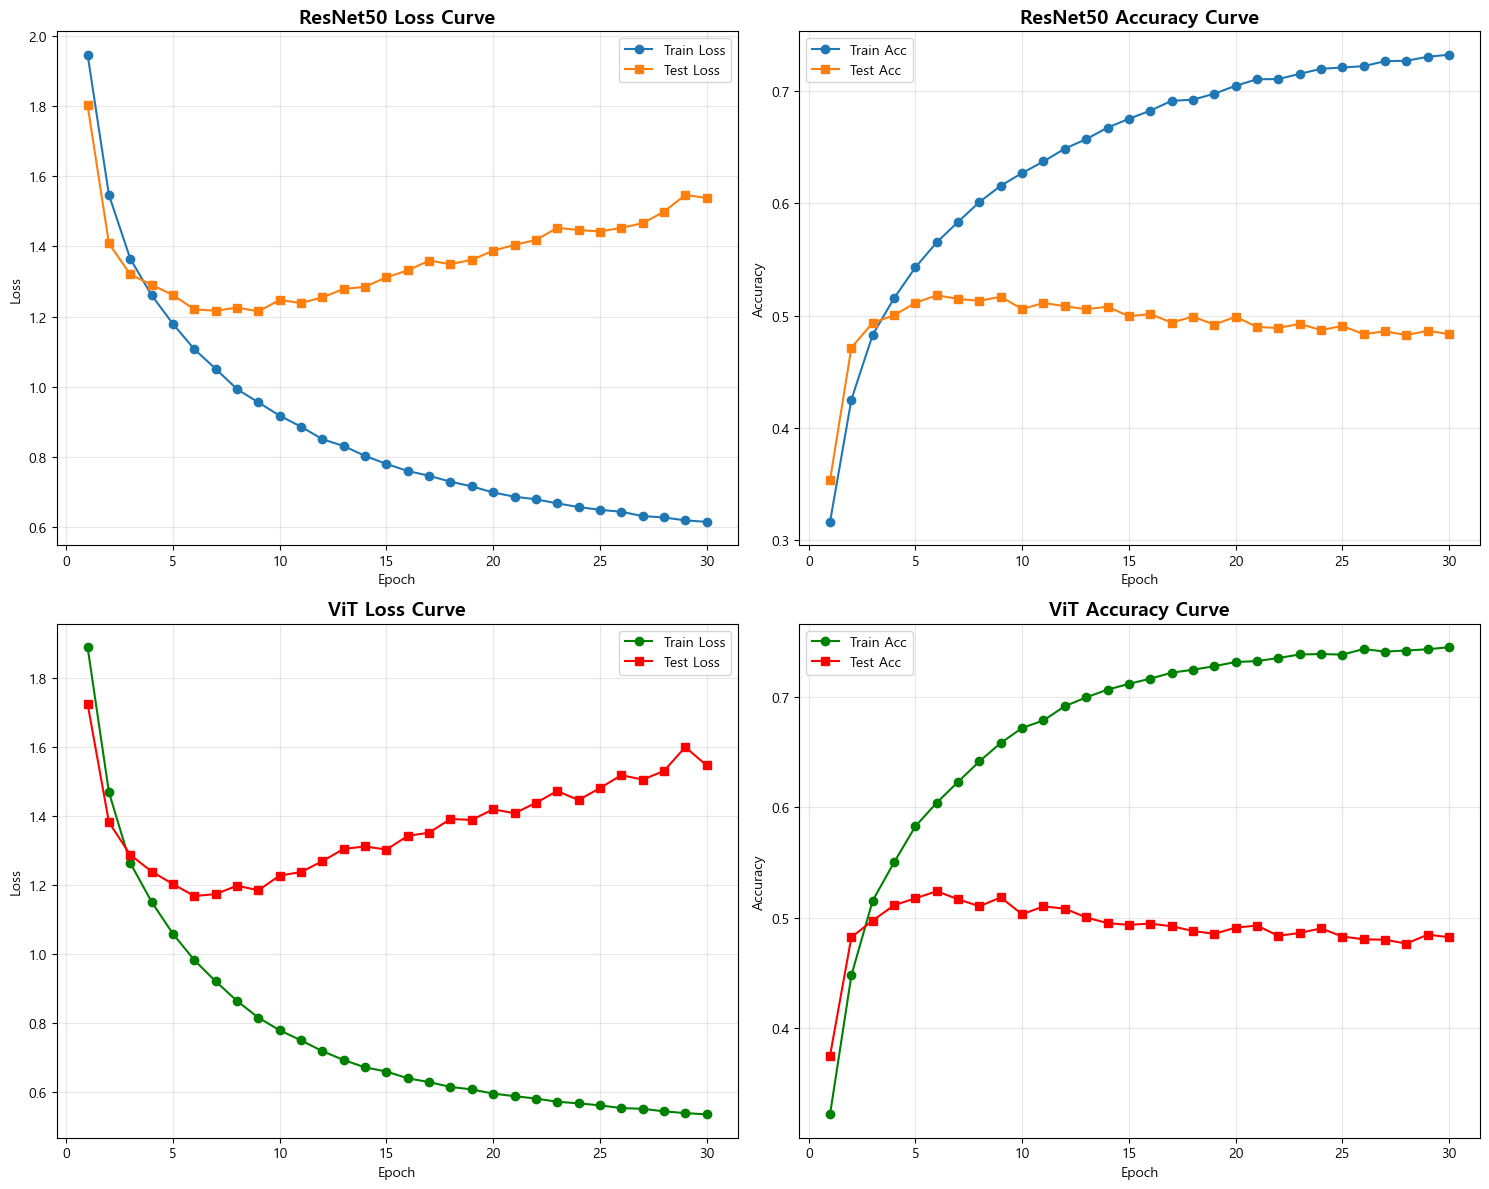

In [ ]:
# 학습 곡선 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# ResNet Loss
axes[0, 0].plot(resnet_log['Epoch'], resnet_log['Train Loss'], label='Train Loss', marker='o')
axes[0, 0].plot(resnet_log['Epoch'], resnet_log['Test Loss'], label='Test Loss', marker='s')
axes[0, 0].set_title('ResNet50 Loss Curve', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# ResNet Accuracy
axes[0, 1].plot(resnet_log['Epoch'], resnet_log['Train Acc'], label='Train Acc', marker='o')
axes[0, 1].plot(resnet_log['Epoch'], resnet_log['Test Acc'], label='Test Acc', marker='s')
axes[0, 1].set_title('ResNet50 Accuracy Curve', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# ResNet F1-Score
if 'Test F1' in resnet_log.columns:
    axes[0, 2].plot(resnet_log['Epoch'], resnet_log['Test F1'], label='Test F1', marker='o', color='purple')
    axes[0, 2].set_title('ResNet50 F1-Score Curve', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1-Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

# ViT Loss
axes[1, 0].plot(vit_log['Epoch'], vit_log['Train Loss'], label='Train Loss', marker='o', color='green')
axes[1, 0].plot(vit_log['Epoch'], vit_log['Test Loss'], label='Test Loss', marker='s', color='red')
axes[1, 0].set_title('ViT Loss Curve', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ViT Accuracy
axes[1, 1].plot(vit_log['Epoch'], vit_log['Train Acc'], label='Train Acc', marker='o', color='green')
axes[1, 1].plot(vit_log['Epoch'], vit_log['Test Acc'], label='Test Acc', marker='s', color='red')
axes[1, 1].set_title('ViT Accuracy Curve', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# ViT F1-Score
if 'Test F1' in vit_log.columns:
    axes[1, 2].plot(vit_log['Epoch'], vit_log['Test F1'], label='Test F1', marker='o', color='orange')
    axes[1, 2].set_title('ViT F1-Score Curve', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('F1-Score')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. 모델별 성능 비교


모델별 성능 비교:
       Model  Train Accuracy  Test Accuracy  Best Test Accuracy  Parameters (M)
    ResNet50          0.7324         0.4835              0.5181            23.5
         ViT          0.0000         0.0000              0.0000            86.4
RandomForest          0.0000         0.0000              0.0000             0.0
     XGBoost          0.0000         0.0000              0.0000             0.0
    Stacking          0.0000         0.0000              0.0000             0.0


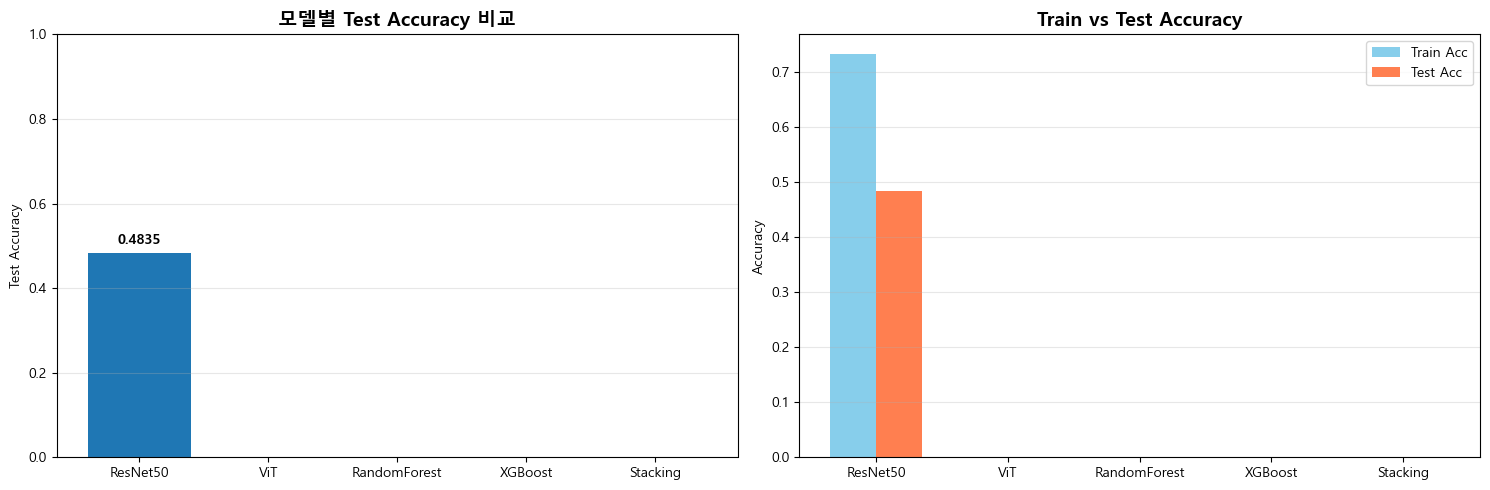

In [4]:
# 모델별 최종 성능 비교 테이블
model_comparison = pd.DataFrame({
    'Model': ['ResNet50', 'ViT', 'RandomForest', 'XGBoost', 'Stacking'],
    'Train Accuracy': [0.7324, 0.0, 0.0, 0.0, 0.0],  # 실제 값으로 업데이트 필요
    'Test Accuracy': [0.4835, 0.0, 0.0, 0.0, 0.0],   # 실제 값으로 업데이트 필요
    'Best Test Accuracy': [0.5181, 0.0, 0.0, 0.0, 0.0],  # 실제 값으로 업데이트 필요
    'Parameters (M)': [23.5, 86.4, 0.0, 0.0, 0.0]  # 모델 파라미터 수
})

print("\n모델별 성능 비교:")
print(model_comparison.to_string(index=False))

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Test Accuracy 비교
ax[0].bar(model_comparison['Model'], model_comparison['Test Accuracy'], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax[0].set_title('모델별 Test Accuracy 비교', fontsize=14, fontweight='bold')
ax[0].set_ylabel('Test Accuracy')
ax[0].set_ylim([0, 1])
ax[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(model_comparison['Test Accuracy']):
    if v > 0:
        ax[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontweight='bold')

# Train vs Test Accuracy
x = np.arange(len(model_comparison))
width = 0.35
ax[1].bar(x - width/2, model_comparison['Train Accuracy'], width, label='Train Acc', color='skyblue')
ax[1].bar(x + width/2, model_comparison['Test Accuracy'], width, label='Test Acc', color='coral')
ax[1].set_title('Train vs Test Accuracy', fontsize=14, fontweight='bold')
ax[1].set_ylabel('Accuracy')
ax[1].set_xticks(x)
ax[1].set_xticklabels(model_comparison['Model'])
ax[1].legend()
ax[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('./results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Confusion Matrix 생성

In [5]:
# 모델 로드 및 테스트 데이터 예측
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 데이터 로더 설정
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(root='./data/test', transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = test_dataset.classes
print(f"클래스: {class_names}")

# ResNet50 모델 로드
model = models.resnet50(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load('best_finetuned_resnet.pth', map_location=device))
model = model.to(device)
model.eval()

# 예측 수행
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: './data/test'

In [ ]:
# Confusion Matrix 시각화
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('ResNet50 Confusion Matrix', fontsize=16, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

## 4. ROC Curve 및 AUC

In [ ]:
# 확률값 추출
all_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

# One-hot encoding
all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))

# ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC curve
fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=3,
         label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - ResNet50', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./results/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n클래스별 AUC:")
for i, name in enumerate(class_names):
    print(f"{name}: {roc_auc[i]:.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:.4f}")

## 5. t-SNE 시각화

In [ ]:
# Feature 추출
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    
    # ResNet의 마지막 fc layer 전 feature 추출
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    
    with torch.no_grad():
        for inputs, lbls in dataloader:
            inputs = inputs.to(device)
            feats = feature_extractor(inputs)
            feats = feats.view(feats.size(0), -1)
            features.append(feats.cpu().numpy())
            labels.append(lbls.numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

print("Feature 추출 중...")
features, labels = extract_features(model, test_loader, device)
print(f"Feature shape: {features.shape}")

# t-SNE 적용
print("t-SNE 계산 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
features_2d = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

for i, name in enumerate(class_names):
    mask = labels == i
    plt.scatter(features_2d[mask, 0], features_2d[mask, 1], 
                c=[colors[i]], label=name, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

plt.title('t-SNE Visualization of Test Set Features (ResNet50)', fontsize=16, fontweight='bold')
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(loc='best', fontsize=9, markerscale=1.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./results/tsne_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. 성능 메트릭 요약

In [ ]:
# 다양한 메트릭 계산
accuracy = accuracy_score(all_labels, all_preds)
f1_macro = f1_score(all_labels, all_preds, average='macro')
f1_weighted = f1_score(all_labels, all_preds, average='weighted')
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')

metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)', 
               'Precision (Macro)', 'Recall (Macro)'],
    'Value': [accuracy, f1_macro, f1_weighted, precision_macro, recall_macro]
})

print("\n=" * 50)
print("ResNet50 성능 메트릭 요약")
print("=" * 50)
print(metrics_summary.to_string(index=False))
print("=" * 50)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(metrics_summary['Metric'], metrics_summary['Value'], color='steelblue')
plt.xlabel('Score', fontsize=12)
plt.title('ResNet50 Performance Metrics', fontsize=14, fontweight='bold')
plt.xlim([0, 1])
for i, v in enumerate(metrics_summary['Value']):
    plt.text(v + 0.02, i, f'{v:.4f}', va='center', fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('./results/performance_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. 오분류 사례 분석

In [ ]:
# 오분류 분석
misclassified_idx = np.where(all_labels != all_preds)[0]
print(f"\n총 오분류 샘플 수: {len(misclassified_idx)} / {len(all_labels)}")
print(f"오분류율: {len(misclassified_idx) / len(all_labels) * 100:.2f}%")

# 클래스별 오분류 분석
misclassified_by_class = {}
for i, name in enumerate(class_names):
    true_class_idx = np.where(all_labels == i)[0]
    misclassified_in_class = np.sum(all_labels[true_class_idx] != all_preds[true_class_idx])
    misclassified_by_class[name] = {
        'count': misclassified_in_class,
        'total': len(true_class_idx),
        'rate': misclassified_in_class / len(true_class_idx) if len(true_class_idx) > 0 else 0
    }

print("\n클래스별 오분류 현황:")
for name, stats in misclassified_by_class.items():
    print(f"{name:25s}: {stats['count']:3d}/{stats['total']:3d} ({stats['rate']*100:5.2f}%)")

# 시각화
class_error_rates = [stats['rate'] for stats in misclassified_by_class.values()]
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_error_rates, color='salmon')
plt.title('클래스별 오분류율', fontsize=14, fontweight='bold')
plt.ylabel('오분류율')
plt.xticks(rotation=45, ha='right')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_error_rates):
    plt.text(i, v + 0.02, f'{v*100:.1f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('./results/misclassification_rates.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. 결과 저장

In [ ]:
# 분석 결과를 CSV로 저장
results_dict = {
    'model_comparison': model_comparison,
    'metrics_summary': metrics_summary,
    'resnet_log': resnet_log,
    'vit_log': vit_log
}

for name, df in results_dict.items():
    df.to_csv(f'./results/{name}.csv', index=False)
    print(f"{name}.csv 저장 완료")

print("\n모든 분석 결과가 ./results/ 폴더에 저장되었습니다.")